# Me 5311 Project Part two 
# - Dynamical Systems Characterization

## 1. Load Data and Visulization

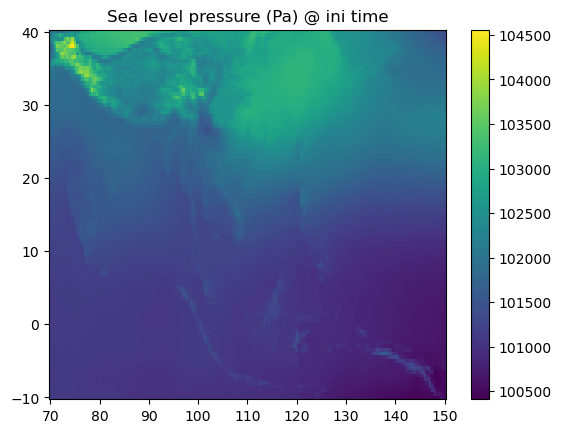

['1979-01-01T11:30:00.000000000' '1979-01-02T11:30:00.000000000'
 '1979-01-03T11:30:00.000000000' ... '2022-12-29T11:30:00.000000000'
 '2022-12-30T11:30:00.000000000' '2022-12-31T11:30:00.000000000']
[ 70.   70.5  71.   71.5  72.   72.5  73.   73.5  74.   74.5  75.   75.5
  76.   76.5  77.   77.5  78.   78.5  79.   79.5  80.   80.5  81.   81.5
  82.   82.5  83.   83.5  84.   84.5  85.   85.5  86.   86.5  87.   87.5
  88.   88.5  89.   89.5  90.   90.5  91.   91.5  92.   92.5  93.   93.5
  94.   94.5  95.   95.5  96.   96.5  97.   97.5  98.   98.5  99.   99.5
 100.  100.5 101.  101.5 102.  102.5 103.  103.5 104.  104.5 105.  105.5
 106.  106.5 107.  107.5 108.  108.5 109.  109.5 110.  110.5 111.  111.5
 112.  112.5 113.  113.5 114.  114.5 115.  115.5 116.  116.5 117.  117.5
 118.  118.5 119.  119.5 120.  120.5 121.  121.5 122.  122.5 123.  123.5
 124.  124.5 125.  125.5 126.  126.5 127.  127.5 128.  128.5 129.  129.5
 130.  130.5 131.  131.5 132.  132.5 133.  133.5 134.  134.5 135.  135

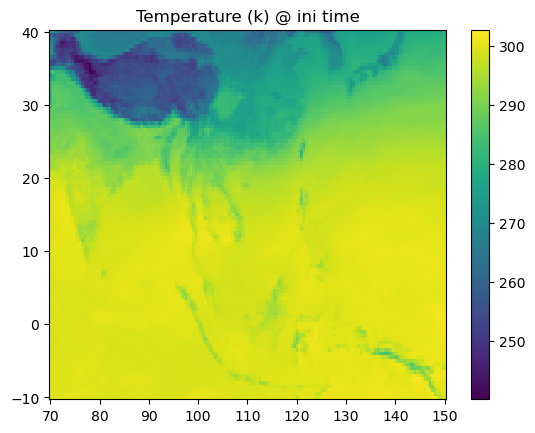

In [23]:
import os
import xarray as xr
import matplotlib.pyplot as plt


# dimensions of data
n_samples = 16071
n_latitudes = 101 
n_longitudes = 161
shape = (n_samples, n_latitudes, n_longitudes)

# load data
ds_slp = xr.open_dataset('slp.nc') # change to 't2m.nc' for temperature data
ds_t = xr.open_dataset('t2m.nc') # change to 't2m.nc' for temperature data

# visualize dataset content
# print(ds)

# get data values
da = ds_slp['msl'] # 'msl' is the variable name for slp, change to 't2m' for temperature data
slp = da.values
# print(slp)
# print(slp.shape)

################## pressure ##################
# get time snapshots
da = ds_slp['time']
t = da.values
# print(t)

# get longitude values
da = ds_slp['longitude']
lon = da.values
# print(lon)

# get latitude values 
da = ds_slp['latitude']
lat = da.values
# print(lat)

## visualization
plt.figure(1)
plt.pcolormesh(lon, lat, slp[0, :, :])
plt.title('Sea level pressure (Pa) @ ini time')
plt.colorbar()
plt.show()

################## Temperature ################
#Temperature
da = ds_t['t2m'] # 'msl' is the variable name for slp, change to 't2m' for temperature data
temp = da.values

# get time snapshots
da = ds_t['time']
t = da.values
print(t)

# get longitude values
da = ds_t['longitude']
lon = da.values
print(lon)

# get latitude values 
da = ds_t['latitude']
lat = da.values
print(lat)

# # ONLY if not enough memory
# low_res_ds = ds[{'longitude': slice(None, None, 2), 'latitude': slice(None, None, 2)}] 
# low_res_ds.to_netcdf(path='slp_low_res.nc') # change to 't2m_low_res.nc' for temperature data

## visualization
plt.figure(2)
plt.pcolormesh(lon, lat, temp[0, :, :])
plt.title('Temperature (k) @ ini time')
plt.colorbar()
plt.show()

## get lat and lon position in matrix
def get_lon(longitude):
    num=np.where(lon==longitude)[0]
    return num
def get_lat(latitude):
    num=np.where(lat==latitude)[0]
    return num

# Taken's Embedding Theorem

Using the Taken's Theorem we can embedd the time series we have available into a phase space where we do not have a temporal dependence between our data points anymore. This is important because the Statistical Learning Theory only guarantees the learning of an algorithm if the samples (rows or data instances) of our dataset are independent from each other.

In order to define this embedding, we need two hyperparameters named d and m which are the time delay and the embedding dimension respectively. The time delay defines how many data points, previously to the actual one, we will use on the embedding. The dimension will define the final shape of our dataset and how many axies there are in the phase space, each axis representing a time delay.

With those two parameters, given a time series $f(t)$, we will have its embedding as:

$$
\begin{matrix}
f(t) & f(t + d) & \dots & f(t + (m-1)d)\\
f(t+1) & f(t + d + 1) & \dots & f(t + (m-1)d + 1)\\
f(t+2) & f(t + d + 2) & \dots & f(t + (m-1)d) + 2)\\
\dots & \dots & \dots & \\
f(t+(m-1)) & f(t + d + (m -1)) & \dots &  f(t + (m-1)d + (m-1))
\end{matrix}
$$

The idea is that if the series is deterministic enough, then this embedding will generate an attractor on the phase space and we will able to forecast the time series.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nolitsa import dimension, delay

import plotly.express as px
import plotly.graph_objects as go

from sktime.datasets import load_airline, load_shampoo_sales, load_lynx

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from openml.datasets.functions import get_dataset

### Embedding the Lorenz data

In [49]:
sing_T = temp[0:, get_lon(104), get_lat(1)]
sing_T=sing_T[0:,0]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t, y=sing_T, mode='lines'
))
fig.show()


The function below will generate the embedding for a series given the m and the d parameters. We will then compare it with the implementation from the Giotto-TDA library to see if we implemented it correctly.

In [26]:
def takens(data, m=2, d=1): 
#m: The embedding dimension (default value is 2) d: The time delay (default value is 1).
    emb = np.array([data[0:len(data) - d*m]])
    for i in range(1, m):
        emb = np.append(emb, [data[i*d:len(data) - d*(m - i)]], axis=0)
        
    return emb.T

### Defining the delay
To find the time delay to be used, we are going to use the Mutual Information of the time series. The idea behind this metric is that the first local minima of the graph is the optimal delay for our embedding. This is an empirical strategy and therefore is not guarantee to generate the best delay possible.

local Max:1098(d)


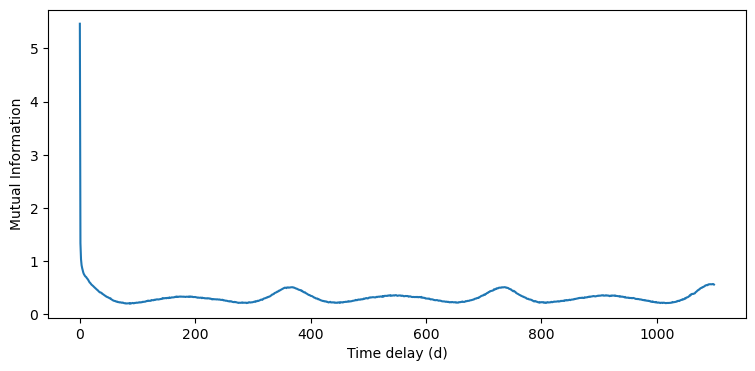

In [55]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (d)')
plt.ylabel('Mutual Information')
Mutual_info=delay.dmi(sing_T, maxtau=1100)
plt.plot(Mutual_info)
print('local Max:'+str(np.argmax(Mutual_info[26:])+27)+'(d)')

As we can see, the first local minima seems to be approximately located on the time delay d=370

In [56]:
def find_optimal_delay(x, maxtau=500):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

### Defining the number of dimensions
To define the number of dimensions, we will use the false nearest neighbors. The false nearest neighbors is a metric that defines, given a dimension space, how many points are being considered as neighbors, but are not really neighbors if we unfold the space with one more dimension.

The common use for this metric is to select the first point where the FNN function returns less than 20%.

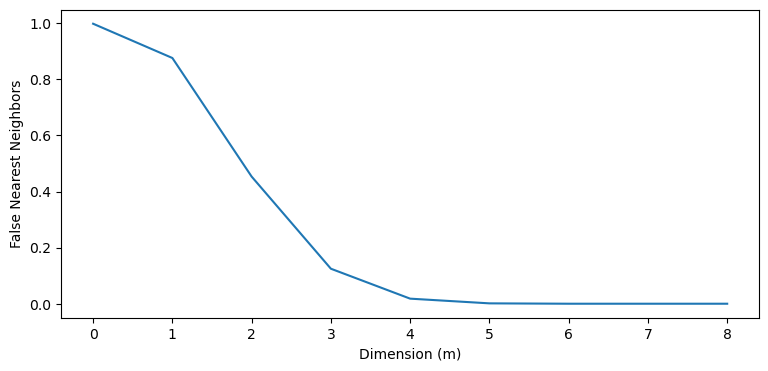

In [57]:
dim = np.arange(1, 10)
sing_T = sing_T.astype(np.float64)
f1, f2, f3 = dimension.fnn(sing_T, tau=370, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (m)')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)

As we can see, for three dimensions the FNN go below 20%, therefore dim=3.
The function below could calculate the proper dimension. 

In [58]:
def find_optional_dimension(x, tau, max_dim=10):
    dim = np.arange(1, max_dim)
    f1, f2, f3 = dimension.fnn(x, tau=tau, dim=dim)

    return np.where(f1 < 0.2)[0][0] + 1

### Now we apply embedding

In [59]:
emb = takens(sing_T, m=3, d=370)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

In [60]:
STE = SingleTakensEmbedding('fixed', 365, 3, n_jobs=-1)
emb = STE.fit_transform(sing_T)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

## Applying the theorem for forecasting
